# Segmentation

## 0. Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Basic Libraries

In [ ]:
# Path
PATH = "/content/drive/MyDrive/McGill/ECSE415/Assignment5"


# Libraries
import time, sys, os, distutils.core

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import cv2

import sklearn
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import flatten
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms


print("numpy: {}".format(np.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("cv2: {}".format(cv2.__version__))
print("sklearn: {}".format(sklearn.__version__))
print("torch: {}".format(torch.__version__))
print("torchvision: {}".format(torchvision.__version__))

numpy: 1.25.2
matplotlib: 3.7.1
cv2: 4.8.0
sklearn: 1.2.2
torch: 2.2.1+cu121
torchvision: 0.17.1+cu121


### Detectron 2

In [ ]:
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15517, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 15517 (delta 74), reused 188 (delta 48), pack-reused 15275
Receiving objects: 100% (15517/15517), 6.39 MiB | 11.39 MiB/s, done.
Resolving deltas: 100% (11185/11185), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=cb5db552b327f1552e39e49154486b3fea259163f1fb392735d4080c42

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

print("detectron2:", detectron2.__version__)

detectron2: 0.6


### Ultralytics

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.9/722.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.1.32 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.9/78.2 GB disk)


## 1. K-Means and Mean-Shift Clustering for Segmentation

### Compute features with Haar filters

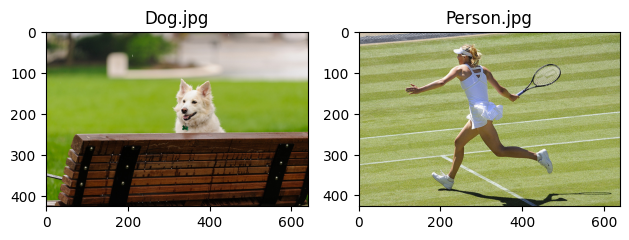

In [ ]:
# loading images
img_1 = cv2.imread(PATH+"/Part 1/Dog.jpg")
#img_1 = cv2.resize(img_1, None, fx=0.3, fy=0.3)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
gray_img_1 = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)

img_2 = cv2.imread(PATH+"/Part 1/Person.jpg")
#img_2 = cv2.resize(img_2, None, fx=0.3, fy=0.3)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
gray_img_2 = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)

plt.subplot(1, 2, 1)
plt.imshow(img_1)
plt.title("Dog.jpg")
plt.subplot(1, 2, 2)
plt.imshow(img_2)
plt.title("Person.jpg")

plt.tight_layout()

In [ ]:
haar_filter_1 = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                          [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
                          [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

haar_filter_2 = np.array([[-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1],
                          [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1],
                          [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1],
                          [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1],
                          [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1],
                          [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1],
                          [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1],
                          [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1],
                          [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1],
                          [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1],
                          [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1],
                          [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]])

filtered_1_img_1 = cv2.filter2D(gray_img_1, -1, haar_filter_1)
filtered_2_img_1 = cv2.filter2D(gray_img_1, -1, haar_filter_2)
filtered_1_img_2 = cv2.filter2D(gray_img_2, -1, haar_filter_1)
filtered_2_img_2 = cv2.filter2D(gray_img_2, -1, haar_filter_2)

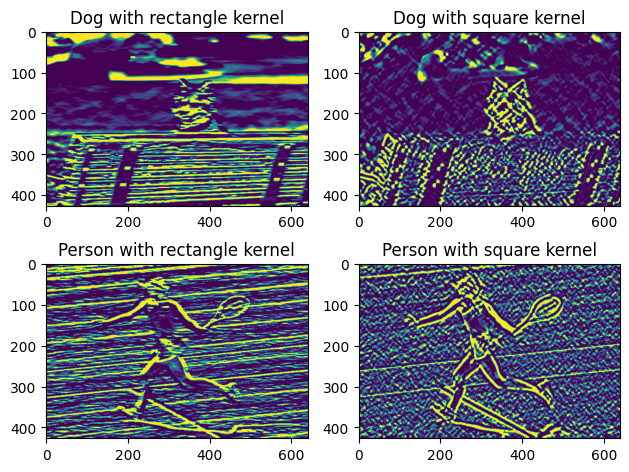

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(filtered_1_img_1)
plt.title("Dog with rectangle kernel")

plt.subplot(2, 2, 2)
plt.imshow(filtered_2_img_1)
plt.title("Dog with square kernel")

plt.subplot(2, 2, 3)
plt.imshow(filtered_1_img_2)
plt.title("Person with rectangle kernel")

plt.subplot(2, 2, 4)
plt.imshow(filtered_2_img_2)
plt.title("Person with square kernel")

plt.tight_layout()

### Implement K-means clustering

#### When 2 filters are applied to the gray scale original image and are stacked

In [ ]:
filtered_img_1 = np.hstack([filtered_1_img_1.reshape(-1, 1), filtered_2_img_1.reshape(-1, 1)])
filtered_img_2 = np.hstack([filtered_1_img_2.reshape(-1, 1), filtered_2_img_2.reshape(-1, 1)])

km_1 = KMeans(n_clusters=3).fit(filtered_img_1)
km_2 = KMeans(n_clusters=3).fit(filtered_img_2)

km_clust_1 = km_1.labels_.reshape(gray_img_1.shape)
km_clust_2 = km_2.labels_.reshape(gray_img_2.shape)

# REFERENCE: https://medium.com/@muhammetbolat/image-segmentation-using-k-means-clustering-algorithm-and-mean-shift-clustering-algorithm-fb6ebe4cb761

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


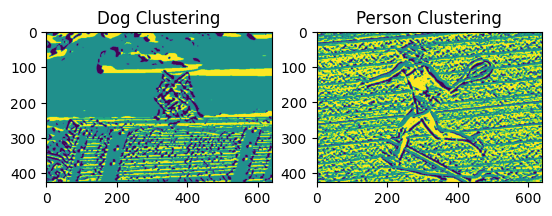

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Dog Clustering")
plt.imshow(km_clust_1)

plt.subplot(1, 2, 2)
plt.title("Person Clustering")
plt.imshow(km_clust_2)

#### When clustering is done on 4 different filtered images

In [ ]:
km_11 = KMeans(n_clusters=3).fit(filtered_1_img_1.reshape(-1, 3))
km_21 = KMeans(n_clusters=3).fit(filtered_2_img_1.reshape(-1, 3))
km_12 = KMeans(n_clusters=3).fit(filtered_1_img_2.reshape(-1, 3))
km_22 = KMeans(n_clusters=3).fit(filtered_2_img_2.reshape(-1, 3))

km_clust_11 = km_11.labels_.reshape(gray_img_1.shape)
km_clust_21 = km_21.labels_.reshape(gray_img_1.shape)
km_clust_12 = km_12.labels_.reshape(gray_img_2.shape)
km_clust_22 = km_22.labels_.reshape(gray_img_2.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


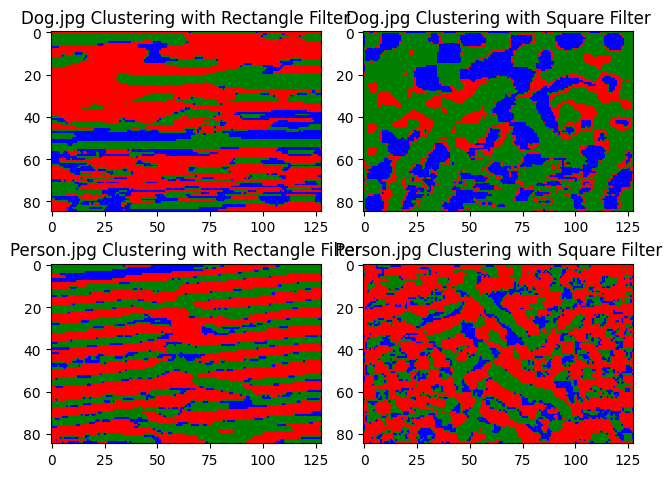

In [ ]:
colors = ['red', 'green', 'blue']
cmap = ListedColormap(colors)

plt.subplot(2, 2, 1)
plt.imshow(km_clust_11, cmap=cmap)
plt.title("Dog.jpg Clustering with Rectangle Filter")

plt.subplot(2, 2, 2)
plt.imshow(km_clust_21, cmap=cmap)
plt.title("Dog.jpg Clustering with Square Filter")

plt.subplot(2, 2, 3)
plt.imshow(km_clust_12, cmap=cmap)
plt.title("Person.jpg Clustering with Rectangle Filter")

plt.subplot(2, 2, 4)
plt.imshow(km_clust_22, cmap=cmap)
plt.title("Person.jpg Clustering with Square Filter")

plt.tight_layout()

### Implement Mean-shift clustering

#### When 2 filters are applied to the gray scale original image and are stacked

In [ ]:
bandwidth_1 = estimate_bandwidth(filtered_img_1, quantile=0.2, n_samples=500)
bandwidth_2 = estimate_bandwidth(filtered_img_2, quantile=0.2, n_samples=500)

ms_1 = MeanShift(bandwidth=bandwidth_1, bin_seeding=True, cluster_all=True).fit(filtered_img_1)
ms_2 = MeanShift(bandwidth=bandwidth_2, bin_seeding=True, cluster_all=True).fit(filtered_img_2)

ms_clust_1 = ms_1.labels_.reshape(gray_img_1.shape)
ms_clust_2 = ms_2.labels_.reshape(gray_img_2.shape)

# REFERENCE: https://medium.com/@muhammetbolat/image-segmentation-using-k-means-clustering-algorithm-and-mean-shift-clustering-algorithm-fb6ebe4cb761

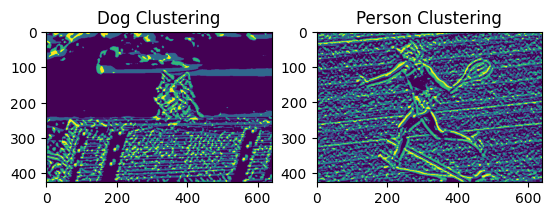

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Dog Clustering")
plt.imshow(ms_clust_1)

plt.subplot(1, 2, 2)
plt.title("Person Clustering")
plt.imshow(ms_clust_2)

#### When clustering is done on 4 different filtered images

In [ ]:
bandwidth_11 = estimate_bandwidth(filtered_1_img_1.reshape(-1, 3), quantile=0.2, n_samples=500)
bandwidth_21 = estimate_bandwidth(filtered_2_img_1.reshape(-1, 3), quantile=0.2, n_samples=500)
bandwidth_12 = estimate_bandwidth(filtered_1_img_2.reshape(-1, 3), quantile=0.2, n_samples=500)
bandwidth_22 = estimate_bandwidth(filtered_2_img_2.reshape(-1, 3), quantile=0.2, n_samples=500)

In [ ]:
ms_11 = MeanShift(bandwidth=bandwidth_11, bin_seeding=True, cluster_all=True).fit(filtered_1_img_1.reshape(-1, 3))
ms_21 = MeanShift(bandwidth=bandwidth_21, bin_seeding=True, cluster_all=True).fit(filtered_2_img_1.reshape(-1, 3))
ms_12 = MeanShift(bandwidth=bandwidth_12, bin_seeding=True, cluster_all=True).fit(filtered_1_img_2.reshape(-1, 3))
ms_22 = MeanShift(bandwidth=bandwidth_22, bin_seeding=True, cluster_all=True).fit(filtered_2_img_2.reshape(-1, 3))


In [ ]:
ms_clust_11 = ms_11.labels_.reshape(gray_img_1.shape)
ms_clust_21 = ms_21.labels_.reshape(gray_img_1.shape)
ms_clust_12 = ms_12.labels_.reshape(gray_img_2.shape)
ms_clust_22 = ms_22.labels_.reshape(gray_img_2.shape)

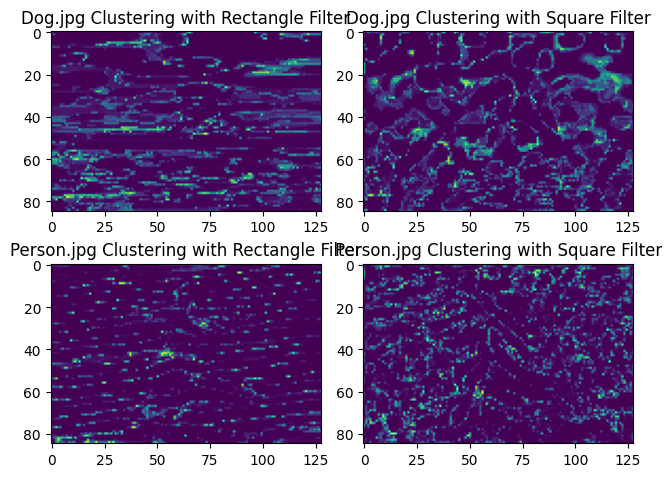

In [ ]:
cmap = "viridis"

plt.subplot(2, 2, 1)
plt.imshow(ms_clust_11, cmap=cmap)
plt.title("Dog.jpg Clustering with Rectangle Filter")

plt.subplot(2, 2, 2)
plt.imshow(ms_clust_21, cmap=cmap)
plt.title("Dog.jpg Clustering with Square Filter")

plt.subplot(2, 2, 3)
plt.imshow(ms_clust_12, cmap=cmap)
plt.title("Person.jpg Clustering with Rectangle Filter")

plt.subplot(2, 2, 4)
plt.imshow(ms_clust_22, cmap=cmap)
plt.title("Person.jpg Clustering with Square Filter")

plt.tight_layout()

#### Discuss the benefits and limitations of these clustering methods for image segmentation.

K-means method performs well when clusters are well-separated and when they are in a circle-like shape. However, it requires the number of clusters (k) to be specified beforehand, which might not always be known. It also assumes that clusters have similar sizes, which might not be the case in real-world data.


On the other hand, Mean-shift method automatically determines the number of clusters based on the data. It can handle clusters of varying shapes and sizes thanks to its adaptive bandwidth parameter. At the expense of this, it can be more computationally expensive.


Comparing the images, the mean-shift clustering performs better on the tennis court background in that the horizontal streaks of noise are more suppressed. It was difficult to further compare the images because the color assignments were inconsistent and the number of clusters were different.

## 2. Neural Network Implementation for Image Segmentation

### Loading Images

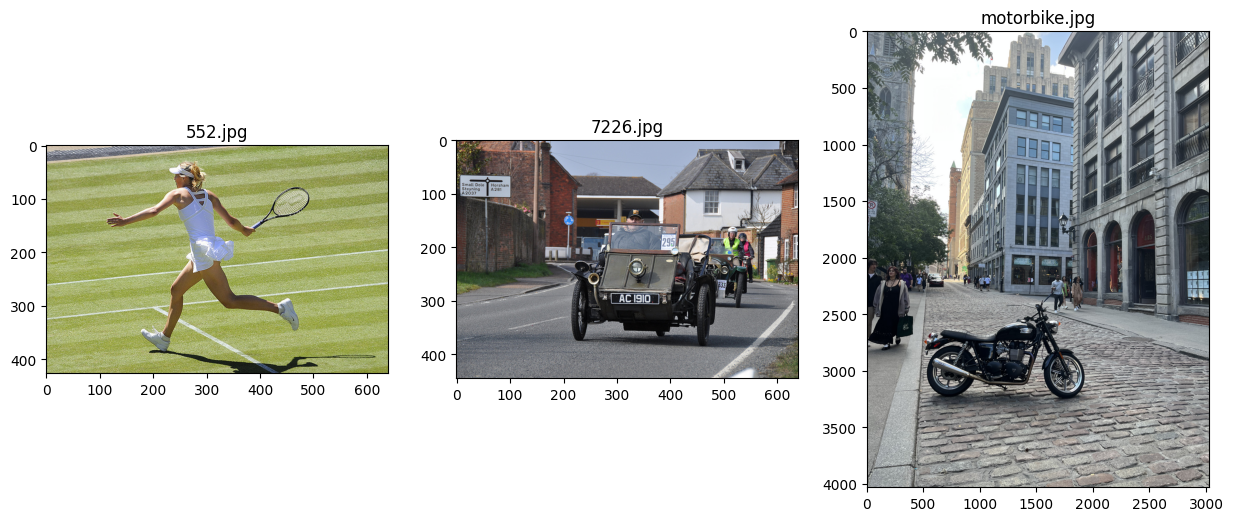

In [ ]:
img_3 = cv2.imread(PATH + "/Part 2/000000000552.jpg")
img_3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB)
img_4 = cv2.imread(PATH + "/Part 2/000000007226.jpg")
img_4 = cv2.cvtColor(img_4, cv2.COLOR_BGR2RGB)
img_5 = cv2.imread(PATH + "/Part 2/motorbike.jpg")
img_5 = cv2.cvtColor(img_5, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.title("552.jpg")
plt.imshow(img_3)

plt.subplot(1, 3, 2)
plt.title("7226.jpg")
plt.imshow(img_4)

plt.subplot(1, 3, 3)
plt.title("motorbike.jpg")
plt.imshow(img_5)

### Mask R-CNN

### Loading Pre-trained Model

In [ ]:
config = get_cfg()
config.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
config.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# REFERENCE: https://github.com/facebookresearch/detectron2

### Predicting on Images

In [ ]:
predictor = DefaultPredictor(config)
outputs_1 = predictor(img_3)
outputs_2 = predictor(img_4)
outputs_3 = predictor(img_5)

# REFERENCE: https://github.com/facebookresearch/detectron2

[03/23 19:54:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:02, 80.1MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Visualizing Segmentation

In [ ]:
v_1 = Visualizer(img_3[:, :, ::-1], MetadataCatalog.get(config.DATASETS.TRAIN[0]), scale=1.2)
v_2 = Visualizer(img_4[:, :, ::-1], MetadataCatalog.get(config.DATASETS.TRAIN[0]), scale=1.2)
v_3 = Visualizer(img_5[:, :, ::-1], MetadataCatalog.get(config.DATASETS.TRAIN[0]), scale=1.2)

out_1 = v_1.draw_instance_predictions(outputs_1["instances"].to("cpu"))
out_2 = v_2.draw_instance_predictions(outputs_2["instances"].to("cpu"))
out_3 = v_3.draw_instance_predictions(outputs_3["instances"].to("cpu"))

# REFERENCE: https://github.com/facebookresearch/detectron2

### Result on 552.jpg

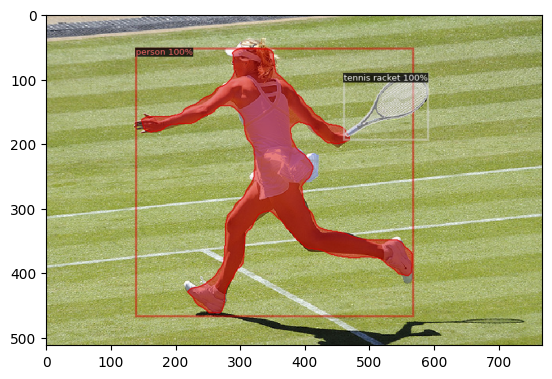

In [ ]:
plt.imshow(out_1.get_image()[:, :, ::-1])

### Result on 7226.jpg

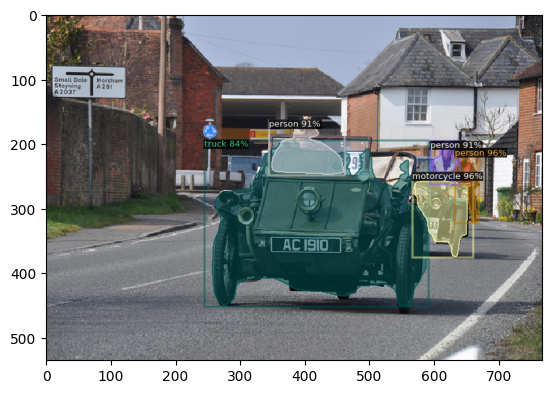

In [ ]:
plt.imshow(out_2.get_image()[:, :, ::-1])

### Result on motorbike.jpg

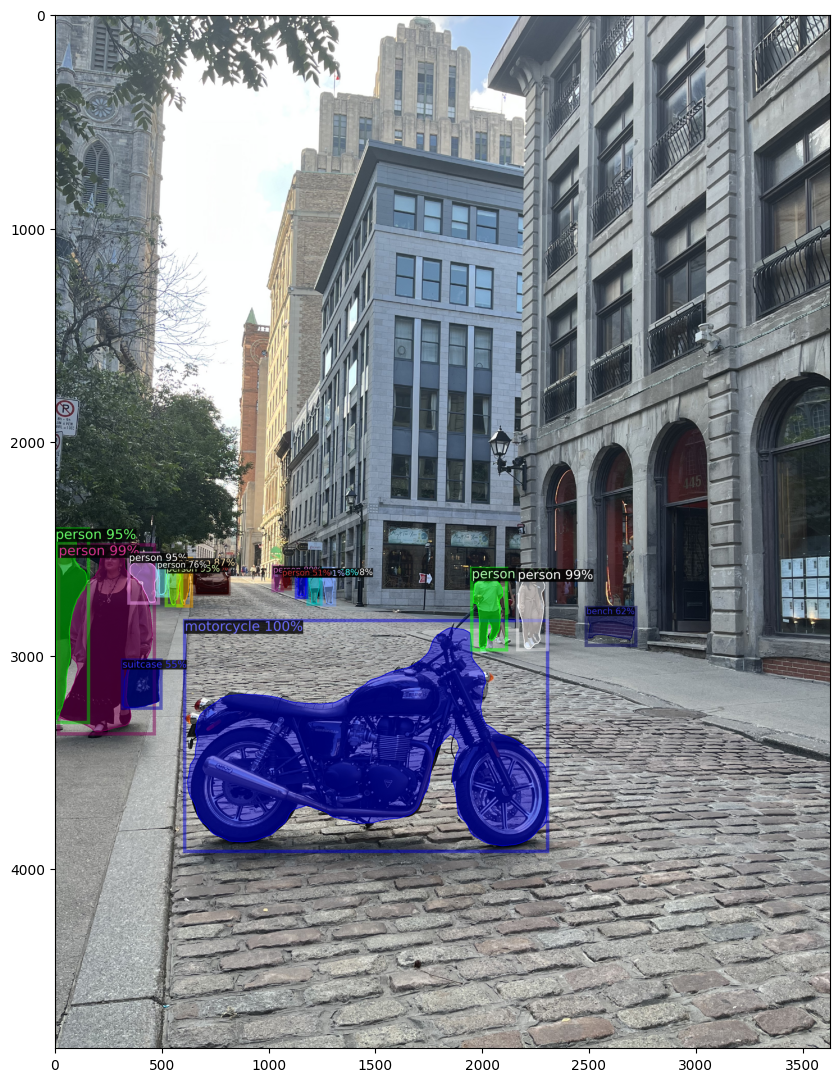

In [ ]:
plt.figure(figsize=(10, 15))
plt.imshow(out_3.get_image()[:, :, ::-1])

### YOLO

### Training Model

In [ ]:
model = YOLO('yolov8n-seg.pt')  # load a pretrained YOLOv8n segmentation model
model.train(data='coco128-seg.yaml', epochs=3)  # train the model

# REFERENCE: https://github.com/ultralytics/ultralytics

100%|██████████| 6.73M/6.73M [00:00<00:00, 101MB/s]


Ultralytics YOLOv8.1.32 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=coco128-seg.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 6.79M/6.79M [00:00<00:00, 144MB/s]
Unzipping /content/datasets/coco128-seg.zip to /content/datasets/coco128-seg...: 100%|██████████| 263/263 [00:00<00:00, 3629.44file/s]

Dataset download success ✅ (1.5s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 24.7MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 118MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/coco128-seg/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 922.09it/s]

train: New cache created: /content/datasets/coco128-seg/labels/train2017.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/coco128-seg/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/3      3.82G      1.093      2.597      1.577      1.176        236        640: 100%|██████████| 8/8 [00:13<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


                   all        128        929      0.658      0.516      0.599      0.447      0.633      0.497      0.562      0.374

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/3      3.77G      1.086      2.506      1.368      1.146        156        640: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        128        929       0.62      0.546      0.611      0.455      0.609      0.508      0.572      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/3      3.74G      1.068       2.59      1.271      1.144        171        640: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        128        929      0.624      0.564      0.618      0.461      0.594      0.535      0.578      0.383



3 epochs completed in 0.011 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 7.1MB
Optimizer stripped from runs/segment/train/weights/best.pt, 7.1MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.1.32 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


                   all        128        929      0.627      0.557      0.619      0.461      0.593      0.529      0.577      0.383
                person        128        254      0.821      0.689      0.783      0.554      0.795      0.669       0.74      0.408
               bicycle        128          6      0.568      0.234      0.405      0.226      0.431      0.167      0.338      0.196
                   car        128         46      0.509      0.196       0.25      0.145      0.503      0.196      0.227      0.102
            motorcycle        128          5      0.821      0.925      0.928      0.726      0.821      0.926      0.928      0.511
              airplane        128          6      0.664      0.833      0.942      0.774      0.531      0.667      0.762      0.557
                   bus        128          7      0.578      0.714       0.72      0.618      0.578      0.714       0.72      0.601
                 train        128          3      0.562      0.873   

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eebaa21d510>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,

### Predicting on Images

In [ ]:
results_1 = model(PATH + "/Part 2/000000000552.jpg")
results_2 = model(PATH + "/Part 2/000000007226.jpg")
results_3 = model(PATH + "/Part 2/motorbike.jpg")

# REFERENCE: https://docs.ultralytics.com/modes/predict/


image 1/1 /content/drive/MyDrive/McGill/ECSE415/Assignment5/Part 2/000000000552.jpg: 448x640 1 person, 1 tennis racket, 266.8ms
Speed: 1.3ms preprocess, 266.8ms inference, 6.8ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/drive/MyDrive/McGill/ECSE415/Assignment5/Part 2/000000007226.jpg: 448x640 5 persons, 3 motorcycles, 1 truck, 23.1ms
Speed: 1.5ms preprocess, 23.1ms inference, 5.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/drive/MyDrive/McGill/ECSE415/Assignment5/Part 2/motorbike.jpg: 640x480 9 persons, 1 car, 1 motorcycle, 1 suitcase, 39.5ms
Speed: 4.1ms preprocess, 39.5ms inference, 6.3ms postprocess per image at shape (1, 3, 640, 480)


### Result on 552.jpg

array([[[182, 169, 148],
        [195, 181, 158],
        [199, 185, 161],
        ...,
        [160, 168, 117],
        [154, 163, 113],
        [187, 198, 149]],

       [[209, 193, 172],
        [199, 185, 163],
        [198, 184, 162],
        ...,
        [160, 169, 116],
        [163, 173, 121],
        [159, 169, 116]],

       [[204, 190, 168],
        [199, 185, 163],
        [201, 187, 165],
        ...,
        [176, 185, 127],
        [164, 176, 117],
        [162, 173, 117]],

       ...,

       [[177, 187, 126],
        [198, 209, 146],
        [142, 155,  89],
        ...,
        [140, 155,  79],
        [129, 144,  66],
        [133, 148,  68]],

       [[159, 169, 109],
        [180, 190, 128],
        [173, 186, 122],
        ...,
        [142, 155,  80],
        [140, 155,  78],
        [136, 151,  72]],

       [[162, 172, 112],
        [171, 182, 122],
        [160, 172, 109],
        ...,
        [146, 158,  85],
        [134, 149,  72],
        [148, 161,  82]]], dtype=uint8)
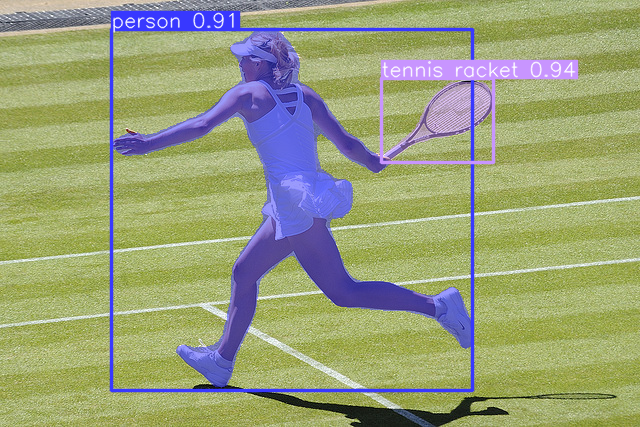

In [ ]:
results_1[0].plot(img=img_3)

### Result on 7226.jpg

array([[[114,  94,  93],
        [110,  80,  82],
        [ 75,  64,  63],
        ...,
        [ 33,  33,  31],
        [ 33,  33,  33],
        [ 32,  32,  34]],

       [[ 95,  76,  69],
        [ 79,  55,  50],
        [ 54,  41,  41],
        ...,
        [ 37,  37,  37],
        [ 28,  28,  28],
        [ 32,  32,  34]],

       [[ 67,  63,  61],
        [ 57,  49,  47],
        [ 48,  48,  47],
        ...,
        [ 36,  36,  36],
        [ 36,  36,  36],
        [ 46,  46,  46]],

       ...,

       [[111, 110, 124],
        [112, 112, 121],
        [114, 118, 122],
        ...,
        [ 86, 100,  65],
        [ 97, 109,  66],
        [ 80,  95,  62]],

       [[ 98,  98, 111],
        [ 89,  90,  95],
        [104, 108, 111],
        ...,
        [ 66,  81,  50],
        [ 78,  88,  54],
        [ 70,  84,  52]],

       [[118, 120, 124],
        [105, 107, 106],
        [121, 122, 124],
        ...,
        [ 77,  89,  50],
        [ 85,  92,  57],
        [ 84,  91,  53]]], dtype=uint8)
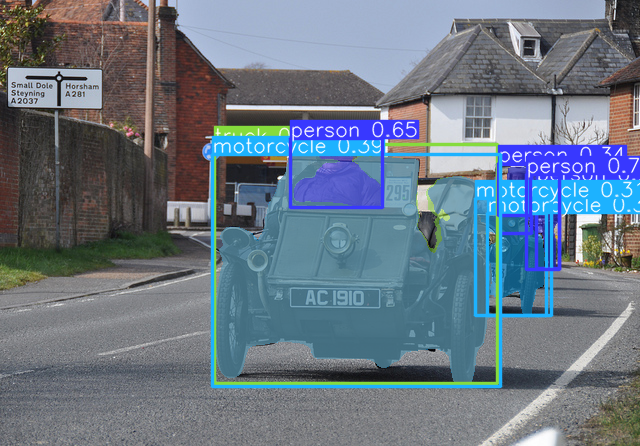

In [ ]:
results_2[0].plot(img=img_4)

### Result on motorbike.jpg

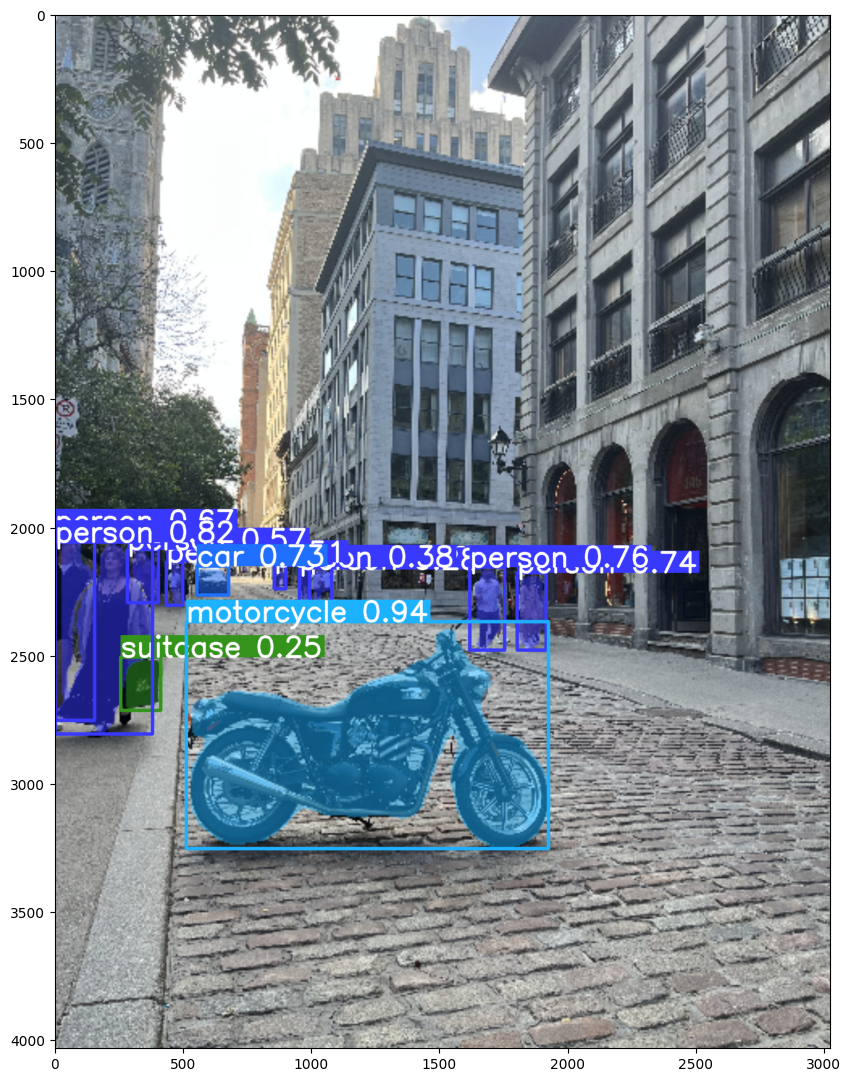

In [ ]:
plt.figure(figsize=(10, 15))
plt.imshow(results_3[0].plot(img=img_5))

### Compare the performance of these two models and explain the steps that Mask R-CNN took to achieve the final result.

Overall, Mask R-CNN had a better accuracy in object classification. Especially in 7226.jpg, the vehicle in the very front was mislabeled as "motorcycle" by YOLO whereas it was correctly labeled as "truck" by Mask R-CNN. The confidence levels of object classification was also relatively higher in Mask R-CNN than in YOLO. Mask R-CNN performed quite well, even with oclusions.

Regarding segmentation, YOLO had a slightly smoother and more accurate coloring area than Mask R-CNN.